### Let's train some models


- **Want**: SavedModel format to upload to Google Storage (GS).
- **Data**: Different slices of Food101 dataset.
- **Model(s)**: EfficientNet with different output layers (e.g. 10 classes, 11 classes, 12 classes).

In [1]:
!nvidia-smi

Wed Sep 29 08:46:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Setup helper functions

In [2]:
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Unzip the downloaded file
def unzip_data(filename):
  """
  Utility function to unzip a zipped file.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [3]:
# Setup data inputs
IMG_SIZE = (224, 224)

def create_data_loaders(train_dir, test_dir, image_size=IMG_SIZE):
  """
  Creates a training and test image BatchDataset from train_dir and test_dir.
  """
  train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  label_mode="categorical",
                                                                  image_size=image_size)
  # Note: the test data is the same as the previous experiment, we could
  # skip creating this, but we'll leave this here to practice.
  test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode="categorical",
                                                                  image_size=image_size)
  
  return train_data, test_data

In [4]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [5]:
# Setup input shape and base model, freezing the base model layers
INPUT_SHAPE = (224, 224, 3)
BASE_MODEL = tf.keras.applications.EfficientNetB0(include_top=False)

def create_model(input_shape=INPUT_SHAPE, base_model=BASE_MODEL, num_classes=10):
  # Fine-tune?
  base_model.trainable = False

  # Create input layer
  inputs = layers.Input(shape=input_shape, name="input_layer")

  # Add in data augmentation Sequential model as a layer
  x = data_augmentation(inputs)

  # Give base_model inputs (after augmentation) and don't train it
  x = base_model(x, training=False)

  # Pool output features of base model
  x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

  # Put a dense layer on as the output
  outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

  # Make a model with inputs and outputs
  model = keras.Model(inputs, outputs)

  # Compile the model
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  
  return model

16719872/16705208 [==============================] - 0s 0us/step


In [7]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=False):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  if scale:
    return img/255.
  else:
    return img

### Download data

In [8]:
# Get data
import zipfile

# Download data (10 class subset of Food101 - https://www.kaggle.com/dansbecker/food-101)
# Already formatted in standard image classification directory style
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2021-09-29 08:48:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   200MB/s    in 2.5s    

2021-09-29 08:48:46 (200 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [9]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [10]:
# Check the file in 10_food_classes_10_percent
!ls -la 10_food_classes_all_data

total 16
drwxr-xr-x  4 root root 4096 Sep 29 08:48 .
drwxr-xr-x  1 root root 4096 Sep 29 08:48 ..
drwxr-xr-x 12 root root 4096 Sep 29 08:48 test
drwxr-xr-x 12 root root 4096 Sep 29 08:48 train


Notice how each of the training directories now has 75 images rather than 750 images. This is key to demonstrating how well transfer learning can perform with less labelled images.

The test directories still have the same amount of images. This means we'll be training on less data but evaluating our models on the same amount of test data.

In [11]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Model 1 ( 10 classes )

In [12]:
# Create BatchDataset
train_data, test_data = create_data_loaders(train_dir="10_food_classes_all_data/train/",
                                            test_dir="10_food_classes_all_data/test/")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [13]:
# What size is our data?
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [14]:
# Create model
model_1 = create_model(num_classes=len(train_data.class_names))

# Fit the model
history_1_percent = model_1.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.25 * len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "all_data_aug")])

Saving TensorBoard log files to: transfer_learning/all_data_aug/20210929-085038
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 142s 443ms/step - loss: 1.0851 - accuracy: 0.6771 - val_loss: 0.5280 - val_accuracy: 0.8438
Epoch 2/5
235/235 [==============================] - 82s 347ms/step - loss: 0.6926 - accuracy: 0.7911 - val_loss: 0.4282 - val_accuracy: 0.8602
Epoch 3/5
235/235 [==============================] - 75s 315ms/step - loss: 0.6230 - accuracy: 0.8036 - val_loss: 0.3992 - val_accuracy: 0.8865
Epoch 4/5
235/235 [==============================] - 70s 293ms/step - loss: 0.5670 - accuracy: 0.8176 - val_loss: 0.3931 - val_accuracy: 0.8701
Epoch 5/5
235/235 [==============================] - 61s 259ms/step - loss: 0.5386 - accuracy: 0.8327 - val_loss: 0.3747 - val_accuracy: 0.8701


In [15]:
# Classes our model is trained on
class_names = train_data.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Save and upload Model 1 to Google Storage

We want to save our model in the TensorFlow [`SavedModel`](https://www.tensorflow.org/guide/saved_model) format because:
  * We're going to upload our `SavedModel` to Google Storage.
  * Then we're link our `SavedModel` to AI platform to serve it ([AI platform requires `SavedModel`](https://cloud.google.com/ai-platform/prediction/docs/deploying-models) format for model serving).

We can do this using: 
1. `model.save("PATH_TO_SAVED_MODEL")` to create a `SavedModel` object (our trained model).
2. Upload the model to Google Storage using the following guide: https://cloud.google.com/storage/docs/uploading-objects#gsutil 

In [17]:
# Save model_1
model_1.save("efficientnet_model_1_10_classes")

INFO:tensorflow:Assets written to: efficientnet_model_1_10_classes/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


The next few cells will allow you to upload files directly from Google Colab to Google Storage.

In [18]:
# Authentic Colab 
# (running this will give you a code to authentic your Google Colab instance, keep the code secret)
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Install and initialize the gcloud command line tool - https://cloud.google.com/sdk/docs/install
# (this will give you access to gcloud tools within Colab)
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init1

Once you've gone through the steps in the above cell, you'll be able to use `gcloud` utilities from Colab.

The main one we're after is copying our model from Colab storage to Google Storage.

For example, running:

```
# Copy local model folder to bucket named "ml_deployment_lec_bucket_0"
!gsutil cp -r efficientnet_model_1_10_classes gs://ml_deploymet_lec_bucket_0
```

But the above line uses my Google Storage bucket/model, yours will look more like:

```
!gsutil cp -r YOUR_MODEL_NAME gs://YOUR_BUCKET_NAME
```

**Note:** To upload anything to a bucket, you will need an existing bucket. See the documentation on [how to create a Google Storage bucket](https://cloud.google.com/storage/docs/creating-buckets).

In [20]:
# Copy model to bucket
!gsutil cp -r efficientnet_model_1_10_classes gs://gcp-food-vision

Copying file://efficientnet_model_1_10_classes/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_1_10_classes/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_1_10_classes/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_1_10_classes/variables/variables.index [Content-Type=application/octet-stream]...
- [4 files][ 22.6 MiB/ 22.6 MiB]                                                
Operation completed over 4 objects/22.6 MiB.                                     


## Model 2 (11 food classes)

Same as model 1 but we've added the donut class.

In [21]:
# Get data
import zipfile

# Download data
!wget https://storage.googleapis.com/ml_deploymet_lec_bucket_0/11_food_classes_all_data.zip # note: this may be broken if using well beyond Feb 10 2021
unzip_data("11_food_classes_all_data.zip")

--2021-09-29 09:11:07--  https://storage.googleapis.com/ml_deploymet_lec_bucket_0/11_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.198.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 570914387 (544M) [application/zip]
Saving to: ‘11_food_classes_all_data.zip’

11_food_classes_all 100%[===================>] 544.47M   146MB/s    in 3.7s    

2021-09-29 09:11:11 (146 MB/s) - ‘11_food_classes_all_data.zip’ saved [570914387/570914387]



In [22]:
# Create data loaders
train_data, test_data = create_data_loaders(train_dir="11_food_classes_all_data/train/",
                                            test_dir="11_food_classes_all_data/test/")

Found 8250 files belonging to 11 classes.
Found 2750 files belonging to 11 classes.


In [23]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'donuts',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [24]:
# Create model
model_2 = create_model(num_classes=len(train_data.class_names))

# Fit model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)))

Epoch 1/5
258/258 [==============================] - 75s 262ms/step - loss: 1.1114 - accuracy: 0.6693 - val_loss: 0.4938 - val_accuracy: 0.8542
Epoch 2/5
258/258 [==============================] - 60s 231ms/step - loss: 0.7062 - accuracy: 0.7855 - val_loss: 0.4159 - val_accuracy: 0.8661
Epoch 3/5
258/258 [==============================] - 62s 238ms/step - loss: 0.6425 - accuracy: 0.8019 - val_loss: 0.3637 - val_accuracy: 0.8914
Epoch 4/5
258/258 [==============================] - 59s 225ms/step - loss: 0.5952 - accuracy: 0.8149 - val_loss: 0.3420 - val_accuracy: 0.8958
Epoch 5/5
258/258 [==============================] - 58s 222ms/step - loss: 0.5524 - accuracy: 0.8264 - val_loss: 0.3385 - val_accuracy: 0.9003


In [25]:
# Save model_2...
model_2.save("efficientnet_model_2_11_classes")

INFO:tensorflow:Assets written to: efficientnet_model_2_11_classes/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Upload Model 2 to Google Storage

In [ ]:
# Auth Colab
from google.colab import auth
auth.authenticate_user()
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

In [27]:
# Upload to GS (requires auth)
!gsutil cp -r efficientnet_model_2_11_classes gs://gcp-food-vision

Copying file://efficientnet_model_2_11_classes/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_2_11_classes/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_2_11_classes/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_2_11_classes/variables/variables.index [Content-Type=application/octet-stream]...
- [4 files][ 22.6 MiB/ 22.6 MiB]                                                
Operation completed over 4 objects/22.6 MiB.                                     


## Model 3 (11 food classes + 5000 non-food images, 12 classes total)

* 11 food classes are same as model 2 above.
* 1 `not_food` class is comprised of ~5000 randomly downloaded images from ImageNet (500 random classes and 10 random images within each of those classes).
  * To do this, I used the script at: https://github.com/mf1024/ImageNet-Datasets-Downloader 

In [28]:
# Get data
import zipfile

# Download data
!wget https://storage.googleapis.com/ml_deploymet_lec_bucket_0/11_food_classes_plus_not_food_class_all_data.zip # note: this may be broken if using well beyond Feb 10 2021
unzip_data("11_food_classes_plus_not_food_class_all_data.zip")

--2021-09-29 09:21:19--  https://storage.googleapis.com/ml_deploymet_lec_bucket_0/11_food_classes_plus_not_food_class_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1053780900 (1005M) [application/zip]
Saving to: ‘11_food_classes_plus_not_food_class_all_data.zip’

11_food_classes_plu 100%[===================>]   1005M   147MB/s    in 6.8s    

2021-09-29 09:21:26 (147 MB/s) - ‘11_food_classes_plus_not_food_class_all_data.zip’ saved [1053780900/1053780900]



In [29]:
# Create data loaders
train_data, test_data = create_data_loaders(train_dir="11_food_classes_plus_not_food_class_all_data/train/",
                                            test_dir="11_food_classes_plus_not_food_class_all_data/test/")

Found 14343 files belonging to 12 classes.
Found 4273 files belonging to 12 classes.


In [30]:
# Create model
model_3 = create_model(num_classes=len(train_data.class_names))

# Fit model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)))

Epoch 1/5
449/449 [==============================] - 104s 215ms/step - loss: 0.9091 - accuracy: 0.7507 - val_loss: 0.5138 - val_accuracy: 0.8769
Epoch 2/5
449/449 [==============================] - 89s 198ms/step - loss: 0.5876 - accuracy: 0.8295 - val_loss: 0.4525 - val_accuracy: 0.8864
Epoch 3/5
449/449 [==============================] - 87s 192ms/step - loss: 0.5294 - accuracy: 0.8454 - val_loss: 0.4308 - val_accuracy: 0.8958
Epoch 4/5
449/449 [==============================] - 87s 192ms/step - loss: 0.4913 - accuracy: 0.8544 - val_loss: 0.4031 - val_accuracy: 0.8958
Epoch 5/5
449/449 [==============================] - 83s 183ms/step - loss: 0.4728 - accuracy: 0.8601 - val_loss: 0.3908 - val_accuracy: 0.9044


In [31]:
# Save model_3...
model_3.save("efficientnet_model_3_12_classes")

INFO:tensorflow:Assets written to: efficientnet_model_3_12_classes/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [32]:
model_3.evaluate(test_data)

134/134 [==============================] - 19s 133ms/step - loss: 0.3953 - accuracy: 0.8942


[0.39526909589767456, 0.8942195177078247]

## Upload Model 3 to Google Storage

In [ ]:
# Auth Colab
from google.colab import auth
auth.authenticate_user()
!curl https://sdk.cloud.google.com | bash 1> /dev/null
!gcloud init

In [34]:
# Upload to GS (requires auth)
!gsutil cp -r efficientnet_model_3_12_classes gs://gcp-food-vision

Copying file://efficientnet_model_3_12_classes/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_3_12_classes/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_3_12_classes/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://efficientnet_model_3_12_classes/variables/variables.index [Content-Type=application/octet-stream]...
- [4 files][ 22.6 MiB/ 22.6 MiB]                                                
Operation completed over 4 objects/22.6 MiB.                                     


## Get test non-food image and make predictions

In [35]:
!wget https://raw.githubusercontent.com/mrdbourke/cs329s-ml-deployment-tutorial/main/food-images/plant.jpeg

--2021-09-29 09:34:23--  https://raw.githubusercontent.com/mrdbourke/cs329s-ml-deployment-tutorial/main/food-images/plant.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542790 (530K) [image/jpeg]
Saving to: ‘plant.jpeg’

plant.jpeg          100%[===================>] 530.07K  --.-KB/s    in 0.04s   

2021-09-29 09:34:23 (12.6 MB/s) - ‘plant.jpeg’ saved [542790/542790]



In [36]:
plant = load_and_prep_image("plant.jpeg")
plant = tf.cast(tf.round(plant), dtype=tf.int32)
plant

<tf.Tensor: shape=(224, 224, 3), dtype=int32, numpy=
array([[[110,  96,  95],
        [107,  93,  92],
        [ 88,  74,  71],
        ...,
        [141, 155, 164],
        [207, 210, 209],
        [242, 241, 237]],

       [[117, 106, 104],
        [117, 106, 103],
        [116, 105, 101],
        ...,
        [132, 144, 152],
        [207, 207, 208],
        [202, 199, 201]],

       [[107,  96,  92],
        [119, 108, 104],
        [102,  91,  87],
        ...,
        [177, 187, 189],
        [206, 204, 202],
        [204, 200, 197]],

       ...,

       [[ 20,  70,  49],
        [ 37,  79,  57],
        [111, 159, 133],
        ...,
        [122, 175, 142],
        [ 84, 143, 110],
        [ 49, 116,  80]],

       [[120, 154, 131],
        [137, 164, 147],
        [108, 127, 111],
        ...,
        [103, 169, 133],
        [ 46,  95,  66],
        [ 83, 143, 110]],

       [[ 43,  83,  62],
        [ 20,  49,  31],
        [ 33,  74,  54],
        ...,
        [ 53, 117,  8

In [37]:
model_3.predict(tf.expand_dims(plant, axis=0))

array([[1.8817223e-04, 6.1438541e-04, 1.8141204e-06, 4.1323481e-04,
        3.0732088e-04, 1.8539028e-04, 3.4542608e-03, 9.8775858e-01,
        7.7692661e-05, 1.4581066e-04, 3.1849814e-03, 3.6682414e-03]],
      dtype=float32)

# Make and plot test predictions

In [38]:
import matplotlib.pyplot as plt

def pred_and_plot(model, image, class_names):
  pred_probs = model.predict(tf.expand_dims(image, axis=0))
  pred_class = class_names[tf.argmax(pred_probs[0])]
  
  plt.figure()
  plt.imshow(image)
  plt.title(f"{pred_class}, prob: {tf.reduce_max(pred_probs):.2f}")
  plt.axis(False);

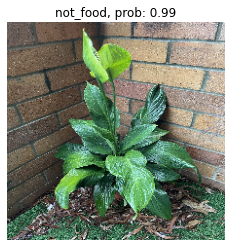

In [39]:
pred_and_plot(model=model_3,
              image=plant,
              class_names=train_data.class_names)

In [40]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'donuts',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'not_food',
 'pizza',
 'ramen',
 'steak',
 'sushi']